## Basic Setup

In [2]:
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd

import os
# run as much as possible accelerated by apple silicon, fall back to cpu if not possible
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch

import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa
from scripts.ipa import filter_chars

In [3]:
import sys, os
sys.path.append('..')
from scripts.eval_tests.panphon_model_eval import panphon_model_eval 

In [4]:
# set espeak library path for macOS
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [5]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

In [6]:
OUTPUT_DIR = os.path.join('..', 'models', 'timit-xlsr-finetune-B')
PRE_TRAINED_ID = "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"

# Load Data

In [7]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [8]:
training_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TRAIN'), timit_files))))

In [9]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

## Clean Up Dataset Vocab 
You will see that the initial vocab of most multilingual phoneme transcription models is quite big (300-400 phonemes) we will reduce this in the dataset to improve overall performance for English

In [10]:
# First, ensure that the simplify_timit function is available and works
def simplify_timit(phoneme):
    # Substitute the phoneme based on the dictionary
    substitution_dict = {
        'ɾ̃': 'ɾ',  # Replace nasalized flap with plain flap
        'ŋ̍': 'ŋ',  # Remove syllabic marker from 'ŋ̍'
        'ə̥': 'ə',  # Remove voiceless marker from 'ə̥'
        'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'l̩': 'l',   # Remove syllabic marker from 'l̩'
        'm̩': 'm',   # Remove syllabic marker from 'm̩'
        'n̩': 'n',   # Remove syllabic marker from 'n̩'
        '̩': '',     # Remove syllabic marker
        'ʉ': 'u',    # Replace high central rounded vowel with high back rounded vowel
        'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
        ' ': '',     # Remove nasalization marker
        'ɦ': 'h',    # Replace voiceless glottal fricative with voiceless glottal fricative
        # Add other necessary substitutions if needed
    }
    # Apply the substitution for the phoneme
    return substitution_dict.get(phoneme, phoneme)  # Return simplified phoneme or the original if no replacement

def remove_stress_mark(text):
    """
    Removes the combining double inverted breve (͡) from text.
    
    Args:
        text: String or iterable containing IPA symbols
        
    Returns:
        Text with stress marks removed
    """
    if isinstance(text, str):
        return text.replace('͡', '')
    else:
        raise TypeError("Input must be string, set, or list")
    
# Updated timit_file_to_dict to use the simplified IPA phonemes
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            
            # Convert to IPA first and then simplify the phoneme
            ipa_phonemes = timit2ipa(phoneme, "eng")
            
            # Now filter only the necessary characters (this simplifies the phoneme to the basic form)
            cleaned_ipa = filter_chars(simplify_timit(ipa_phonemes), filter_type="letters")
            cleaned_ipa = remove_stress_mark(cleaned_ipa)
            timestamped_phonemes.append((cleaned_ipa, int(start), int(end)))

    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}

# Updated files_to_df to create DataFrame with cleaned-up phonemes
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

# Call files_to_df for your test files
train_df = files_to_df(training_files)
train_df.head()


,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ɪtsiliɡiltəpoʊsteɪtəttʃɛk,"[0, 2240, 3400, 3990, 5160, 5806, 7227, 9053, ...","[2240, 3400, 3990, 5160, 5806, 7227, 9053, 100..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðimɪspɹɪntɹvoʊkɪɾimiɾiitiskleɪmɹ,"[0, 2310, 2740, 3425, 4637, 6060, 7352, 8550, ...","[2310, 2740, 3425, 4637, 6060, 7352, 8550, 954..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃiɛddʒɹdɑɹksuʔiŋɡɹiziwɔʃwɔɾɹʔɔljɪɹ,"[0, 2154, 3610, 4540, 5960, 6610, 7462, 8440, ...","[2154, 3610, 4540, 5960, 6610, 7462, 8440, 945..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðɛɹɪmeɪndəlaɪflɔŋfɹɛnzinkəmpænjinz,"[0, 2310, 2780, 3506, 3960, 5240, 6240, 8560, ...","[2310, 2780, 3506, 3960, 5240, 6240, 8560, 934..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðɪnuzeɪdʒnsihaɪɹɾəɡɹeɪtdʒɹɾləst,"[0, 2088, 2450, 3634, 4595, 7640, 8290, 10610,...","[2088, 2450, 3634, 4595, 7640, 8290, 10610, 11..."


### Cleaning Up Audio
We will just crop out the start signal :)

In [11]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]
    
    return cropped_audio

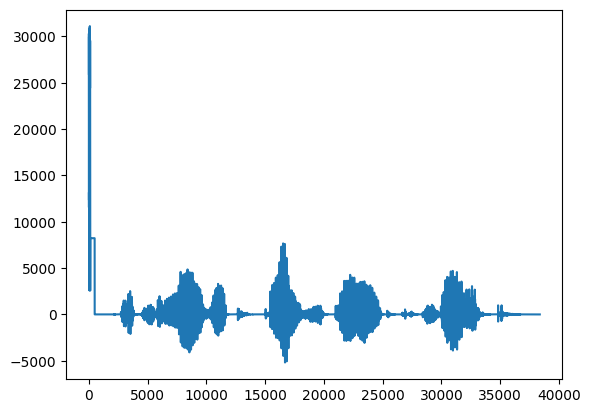

In [12]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(train_df['audio'][0])
plt.show()

In [13]:
# Apply the process_row function to each row in the DataFrame
train_df['cropped_audio'] = train_df.apply(crop_audio, axis=1) 
train_df.head()
    

,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ɪtsiliɡiltəpoʊsteɪtəttʃɛk,"[0, 2240, 3400, 3990, 5160, 5806, 7227, 9053, ...","[2240, 3400, 3990, 5160, 5806, 7227, 9053, 100...","[5, 1, 6, 8, 0, 4, 3, 3, 0, 5, 3, -1, -2, 3, 0..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðimɪspɹɪntɹvoʊkɪɾimiɾiitiskleɪmɹ,"[0, 2310, 2740, 3425, 4637, 6060, 7352, 8550, ...","[2310, 2740, 3425, 4637, 6060, 7352, 8550, 954...","[6, 7, 7, 6, 8, 8, 1, 3, 0, -2, 1, 1, -2, -2, ..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃiɛddʒɹdɑɹksuʔiŋɡɹiziwɔʃwɔɾɹʔɔljɪɹ,"[0, 2154, 3610, 4540, 5960, 6610, 7462, 8440, ...","[2154, 3610, 4540, 5960, 6610, 7462, 8440, 945...","[4, 1, 4, 2, 0, 0, 3, 3, 4, 0, 3, 3, -1, 0, -1..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðɛɹɪmeɪndəlaɪflɔŋfɹɛnzinkəmpænjinz,"[0, 2310, 2780, 3506, 3960, 5240, 6240, 8560, ...","[2310, 2780, 3506, 3960, 5240, 6240, 8560, 934...","[0, 0, -3, 0, 4, 1, 0, 6, 2, -4, 0, 1, 8, 0, 5..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðɪnuzeɪdʒnsihaɪɹɾəɡɹeɪtdʒɹɾləst,"[0, 2088, 2450, 3634, 4595, 7640, 8290, 10610,...","[2088, 2450, 3634, 4595, 7640, 8290, 10610, 11...","[0, -2, -3, 3, 3, 0, 0, 3, 1, 0, 3, 1, 0, 0, 0..."


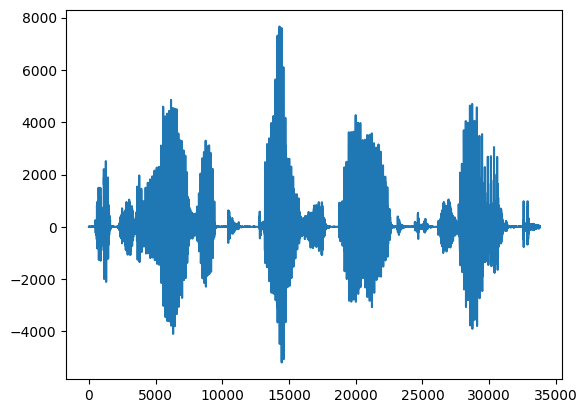

In [14]:
# visualize again, much better!
plt.plot(train_df['cropped_audio'][0])


In [15]:
# train_df comprised of just cropped_audio and phonemes
train_df = train_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
# rename cropped audio to audio
train_df = train_df.rename(columns={'cropped_audio': 'audio'})
train_df.head()

,ipa,audio
0,ɪtsiliɡiltəpoʊsteɪtəttʃɛk,"[5, 1, 6, 8, 0, 4, 3, 3, 0, 5, 3, -1, -2, 3, 0..."
1,ðimɪspɹɪntɹvoʊkɪɾimiɾiitiskleɪmɹ,"[6, 7, 7, 6, 8, 8, 1, 3, 0, -2, 1, 1, -2, -2, ..."
2,ʃiɛddʒɹdɑɹksuʔiŋɡɹiziwɔʃwɔɾɹʔɔljɪɹ,"[4, 1, 4, 2, 0, 0, 3, 3, 4, 0, 3, 3, -1, 0, -1..."
3,ðɛɹɪmeɪndəlaɪflɔŋfɹɛnzinkəmpænjinz,"[0, 0, -3, 0, 4, 1, 0, 6, 2, -4, 0, 1, 8, 0, 5..."
4,ðɪnuzeɪdʒnsihaɪɹɾəɡɹeɪtdʒɹɾləst,"[0, -2, -3, 3, 3, 0, 0, 3, 1, 0, 3, 1, 0, 0, 0..."


In [16]:
train_ds = Dataset.from_pandas(train_df)

# Extend Phoneme Vocab

In [17]:
timit_vocab = set("".join(train_df['ipa']))
print(timit_vocab)

{'ʊ', 'n', 'k', 'ɔ', 'w', 'ʒ', 'u', 'æ', 'ɪ', 'ð', 'o', 'm', 'a', 'f', 'ɡ', 'e', 'h', 't', 'j', 'l', 'ʔ', 's', 'ɛ', 'd', 'ʌ', 'θ', 'ɑ', 'b', 'ə', 'p', 'v', 'ɾ', 'ŋ', 'i', 'z', 'ɹ', 'ʃ'}


In [18]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()
# you will see how large the vocab is, we will resize our linear layer later to make it work for our smaller vocab
print(vocab)

{'A': 267, 'E': 45, 'H': 72, 'I': 20, 'O': 305, 'U': 292, '[PAD]': 310, '[UNK]': 309, '_': 182, 'a': 53, 'ã': 125, 'b': 113, 'b̪': 177, 'b̪͡v': 289, 'b͡ꞵ': 287, 'c': 25, 'cʼ': 229, 'c͡ç': 66, 'd': 176, 'd̼': 118, 'd͡z': 263, 'd͡ð': 244, 'd͡ɮ': 18, 'd͡ʑ': 94, 'd͡ʒ': 280, 'e': 175, 'ẽ': 211, 'e̞': 114, 'ẽ̞': 265, 'f': 139, 'fʼ': 249, 'h': 179, 'i': 245, 'j': 215, 'k': 282, 'kxʼ': 281, 'kǀ': 41, 'kǁ': 61, 'kǂ': 21, 'kǃ': 70, 'kʘ': 79, 'kʼ': 39, 'k̚': 89, 'k͡p': 48, 'k͡x': 198, 'l': 303, 'm': 75, 'm̥': 172, 'n': 102, 'n̥': 28, 'n̼': 169, 'o': 117, 'õ': 119, 'o̞': 62, 'õ̞': 234, 'p': 259, 'pʼ': 286, 'p̚': 149, 'p̪': 273, 'p̪͡f': 105, 'p͡f': 225, 'p͡ɸ': 103, 'q': 130, 'qǀ': 302, 'qǁ': 126, 'qǂ': 299, 'qǃ': 37, 'qʘ': 261, 'qʼ': 58, 'q͡ʡ': 127, 'q͡χʼ': 291, 'q͡ꭓ': 4, 'r': 82, 'r̥': 34, 's': 247, 'sʼ': 200, 't': 307, 'tʼ': 183, 't̚': 241, 't̪͡θʼ': 216, 't̼': 87, 't͡s': 156, 't͡sʼ': 43, 't͡ɕ': 264, 't͡ɬ': 170, 't͡ɬʼ': 164, 't͡ʃ': 91, 't͡ʃʼ': 108, 't͡θ': 140, 'u': 154, 'ũ': 81, 'v': 243, 'w

In [19]:
additional_vocab = timit_vocab.difference(set(vocab.keys()) | {' '})
print("tokens that are in timit but not in the pretrained model", additional_vocab)
tokenizer.add_tokens(list(additional_vocab))

tokens that are in timit but not in the pretrained model set()


0

# Update Feature Extraction

In [20]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

# FINE-TUNE!


In [21]:
%pip install torchaudio

Note: you may need to restart the kernel to use updated packages.


In [22]:
import torch
import tempfile
from transformers import AutoProcessor, AutoModelForCTC, Trainer, TrainingArguments, Wav2Vec2CTCTokenizer
from datasets import Dataset
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import logging
from torch.utils.data import DataLoader
import wandb
import os
from sklearn.model_selection import train_test_split
import torchaudio
import json
from transformers.trainer_callback import EarlyStoppingCallback

#B1- LESS TRAINING EPOCHS
#B2- LENGTH PENALTY 
#B3- MORE TRAINING EPOCHS

NEW_MODEL_ID = "./notebooks/results-b0"

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Constants
SAMPLING_RATE = 16000
MAX_AUDIO_LENGTH = 160000  # 10 seconds at 16kHz
MAX_LABEL_LENGTH = 100

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    """
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Add max length check
        max_length = min(
            max(len(feature["input_values"]) for feature in features),
            MAX_AUDIO_LENGTH
        )
        # Pad input_values
        padded_inputs = []
        attention_mask = []
        for feature in features:
            input_length = len(feature["input_values"])
            padding_length = max_length - input_length
            
            # Convert to tensor and ensure correct shape
            if isinstance(feature["input_values"], list):
                input_values = torch.tensor(feature["input_values"])
            else:
                input_values = feature["input_values"]
            
            # Remove any extra dimensions and ensure it's 1D
            input_values = input_values.squeeze()
            
            # Pad with zeros
            if padding_length > 0:
                padded_input = torch.nn.functional.pad(input_values, (0, padding_length))
                attention_mask.append(torch.cat([torch.ones(input_length), torch.zeros(padding_length)]))
            else:
                padded_input = input_values
                attention_mask.append(torch.ones(input_length))
            
            padded_inputs.append(padded_input)

        # Stack all padded inputs
        batch = {
            "input_values": torch.stack(padded_inputs),
            "attention_mask": torch.stack(attention_mask)
        }

        # Process labels
        with self.processor.as_target_processor():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # Replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

def prepare_model_and_processor(timit_vocab):
    """
    Original function that resizes the linear layer to match TIMIT vocab.
    """
    logger.info("Loading pretrained model and processor...")
    
    processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
    model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)
    
    # Store the old vocabulary before making any changes
    old_vocab = processor.tokenizer.get_vocab()
    logger.info(f"Initial vocabulary size: {len(old_vocab)}")
    
    # Define fixed special token IDs - pad token first for CTC
    special_tokens = {
        "<pad>": 0,  # Changed to 0 for CTC blank token
        "<s>": 1,    # Shifted up
        "</s>": 2,   # Shifted up
        "<unk>": 3   # Shifted up
    }
    
    # Get regular tokens (excluding special tokens)
    regular_tokens = sorted(list(timit_vocab - set(special_tokens.keys())))
    
    # Create combined vocabulary with fixed IDs
    vocab = {**special_tokens}  # Start with special tokens
    
    # Add regular tokens after special tokens
    for idx, token in enumerate(regular_tokens):
        vocab[token] = idx + len(special_tokens)
    
    # Create tokenizer config
    tokenizer_config = {
        "vocab": vocab,
        "pad_token": "<pad>",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "<unk>",
    }
    
    # Save vocab to temporary file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        json.dump(vocab, f)
        vocab_path = f.name
    
    # Create new tokenizer
    new_tokenizer = Wav2Vec2CTCTokenizer(
        vocab_path,
        **{k: v for k, v in tokenizer_config.items() if k != "vocab"}
    )
    
    # Update processor with new tokenizer
    processor.tokenizer = new_tokenizer
    os.remove(vocab_path)
    
    # Handle model weights
    old_weights = model.lm_head.weight.data
    old_bias = model.lm_head.bias.data
    
    # Create new layer with smaller size
    new_layer = torch.nn.Linear(model.lm_head.in_features, len(processor.tokenizer))
    new_layer.weight.data.zero_()
    new_layer.bias.data.zero_()
    
    # Transfer weights and bias using the stored old_vocab
    for token, new_idx in new_tokenizer.get_vocab().items():
        if token in old_vocab:
            old_idx = old_vocab[token]
            new_layer.weight.data[new_idx, :] = old_weights[old_idx, :]
            new_layer.bias.data[new_idx] = old_bias[old_idx]
    
    model.lm_head = new_layer
    model.config.vocab_size = len(processor.tokenizer)
    model.config.pad_token_id = 0
    
    return model, processor

def prepare_model_and_processor_no_resize(timit_vocab):
    """
    New function that keeps the original linear layer size.
    """
    logger.info("Loading pretrained model and processor (no resize version)...")
    
    processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
    model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)
    
    # Store the old vocabulary
    old_vocab = processor.tokenizer.get_vocab()
    logger.info(f"Initial vocabulary size: {len(old_vocab)}")
    original_vocab_size = len(old_vocab)
    
    # Define fixed special token IDs
    special_tokens = {
        "<pad>": 0,
        "<s>": 1,
        "</s>": 2,
        "<unk>": 3
    }
    
    # Create new vocabulary mapping while keeping original size
    vocab = {**special_tokens}
    
    # Add TIMIT tokens after special tokens
    regular_tokens = sorted(list(timit_vocab - set(special_tokens.keys())))
    for idx, token in enumerate(regular_tokens):
        vocab[token] = idx + len(special_tokens)
        
    # Fill remaining indices with unused tokens to maintain original size
    current_size = len(vocab)
    for i in range(current_size, original_vocab_size):
        vocab[f"<unused{i}>"] = i
        
    # Save vocab to temporary file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        json.dump(vocab, f)
        vocab_path = f.name
    
    # Create new tokenizer
    tokenizer_config = {
        "pad_token": "<pad>",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "<unk>",
    }
    
    new_tokenizer = Wav2Vec2CTCTokenizer(
        vocab_path,
        **tokenizer_config
    )
    
    # Update processor with new tokenizer
    processor.tokenizer = new_tokenizer
    os.remove(vocab_path)
    
    # Keep original linear layer - no resizing
    logger.info(f"Linear layer size maintained at: {model.lm_head.out_features}")
    
    return model, processor

def preprocess_audio(audio_input):
    """
    Load and preprocess audio to match expected format.
    """
    # Handle different input types
    if isinstance(audio_input, str):  # File path
        waveform, sample_rate = torchaudio.load(audio_input)
        audio_numpy = waveform.squeeze().numpy()
        
    elif isinstance(audio_input, list):  # List input
        audio_numpy = np.array(audio_input, dtype=np.float32)
        
    elif isinstance(audio_input, np.ndarray):  # Already numpy array
        audio_numpy = audio_input
        
    elif isinstance(audio_input, torch.Tensor):  # Torch tensor
        audio_numpy = audio_input.numpy()
        
    else:
        raise ValueError(f"Unsupported audio type: {type(audio_input)}")
    
    # Ensure float32 dtype
    audio_numpy = audio_numpy.astype(np.float32)
    
    # Ensure 1D array
    if len(audio_numpy.shape) > 1:
        audio_numpy = np.mean(audio_numpy, axis=0)
    
    # Normalize audio
    if np.abs(audio_numpy).max() > 1:
        audio_numpy = audio_numpy / np.abs(audio_numpy).max()
    
    # Trim or pad to max length
    if len(audio_numpy) > MAX_AUDIO_LENGTH:
        audio_numpy = audio_numpy[:MAX_AUDIO_LENGTH]
    elif len(audio_numpy) < MAX_AUDIO_LENGTH:
        padding = np.zeros(MAX_AUDIO_LENGTH - len(audio_numpy), dtype=np.float32)
        audio_numpy = np.concatenate([audio_numpy, padding])
    
    return audio_numpy

def prepare_datasets(train_df, processor):
    """
    Dataset preparation with multiprocessing disabled for stability
    """
    logger.info("Splitting dataset into train and evaluation...")
    
    train_data, eval_data = train_test_split(train_df, test_size=0.2, random_state=42)
    
    def process_data(batch):
        # Preprocess audio
        audio = preprocess_audio(batch["audio"])
        audio = audio.squeeze()
        
        # Process audio without any padding or tensor conversion
        inputs = processor(
            audio, 
            sampling_rate=SAMPLING_RATE, 
            return_tensors=None
        )
        
        input_values = np.squeeze(inputs["input_values"])
        
        # Process labels without any padding or tensor conversion
        with processor.as_target_processor():
            labels = processor(batch["ipa"]).input_ids
        
        return {
            "input_values": input_values,
            "labels": labels,
            "audio": audio
        }
    
    # Convert DataFrames to Datasets
    train_dataset = Dataset.from_pandas(train_data)
    eval_dataset = Dataset.from_pandas(eval_data)
    
    # Apply processing without multiprocessing
    train_dataset = train_dataset.map(
        process_data,
        remove_columns=[col for col in train_dataset.column_names if col != "audio"],
        batch_size=32,  # Keep batch processing for efficiency
        num_proc=None  # Disable multiprocessing
    )
    eval_dataset = eval_dataset.map(
        process_data,
        remove_columns=[col for col in eval_dataset.column_names if col != "audio"],
        batch_size=32,
        num_proc=None  # Disable multiprocessing
    )
    
    return train_dataset, eval_dataset
def verify_dimensions(batch, logger):
    """Debug helper to verify tensor dimensions"""
    logger.info("Batch dimensions:")
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            logger.info(f"{key}: {value.shape}")

def verify_token_ids(processor, stage=""):
    """Simple token verification function"""
    logger.info(f"\n=== Token ID Verification [{stage}] ===")
    vocab = processor.tokenizer.get_vocab()
    logger.info(f"Vocabulary size: {len(vocab)}")
    
    # Check special tokens
    special_tokens = ["<pad>", "<s>", "</s>", "<unk>"]
    for token in special_tokens:
        token_id = vocab.get(token)
        logger.info(f"Token {token}: ID {token_id}")
    
    # Sample a few regular tokens
    regular_tokens = [t for t in list(vocab.keys())[:5] if t not in special_tokens]
    logger.info("Sample regular token IDs:")
    for token in regular_tokens:
        logger.info(f"Token {token}: ID {vocab[token]}")
    
    return vocab

def main_experiment(train_df, timit_vocab, resize_linear=False):
    """
    Modified main function to run experiments with and without linear layer resizing
    """
    experiment_name = "linear_resize" if resize_linear else "linear_no_resize"
    wandb.init(project="xlsr-buckeye-phoneme-prediction-linear-size", name=experiment_name)
    
    # Choose model preparation function based on experiment
    if resize_linear:
        model, processor = prepare_model_and_processor(timit_vocab)  # Original function
    else:
        model, processor = prepare_model_and_processor_no_resize(timit_vocab)  # New function
    
    # Log linear layer size
    logger.info(f"Linear layer output size: {model.lm_head.out_features}")
    wandb.log({"linear_layer_size": model.lm_head.out_features})
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.gradient_checkpointing_enable()
    
    train_dataset, eval_dataset = prepare_datasets(train_df, processor)
    
    training_args = TrainingArguments(
        output_dir=f"./results-{experiment_name}",
        learning_rate=8e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=4,
        max_grad_norm=0.907,
        adam_beta1=0.93287,
        adam_beta2=0.96748,
        warmup_ratio=0.08253,
        lr_scheduler_type="cosine_with_restarts",
        num_train_epochs=40,
        logging_dir='./logs',
        logging_steps=10,
        save_steps=300,
        eval_steps=50,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_safetensors=True,
        save_strategy="steps",
        save_total_limit=3,
        fp16=True,
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
        gradient_checkpointing=True,
    )
    
    data_collator = DataCollatorCTCWithPadding(
        processor=processor,
        padding="longest"
    )
    
    # Add early stopping callback
    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=5,
        early_stopping_threshold=0.01
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        callbacks=[early_stopping]
    )
    
    # Train and save metrics
    train_result = trainer.train()
    metrics = train_result.metrics
    
    # Log final metrics
    wandb.log({
        "final_train_loss": metrics["train_loss"],
        "vocab_size": len(processor.tokenizer.get_vocab()),
        "linear_size": model.lm_head.out_features
    })
    
    # Save the final model and processor
    model.save_pretrained(f"./results-{experiment_name}")
    processor.save_pretrained(f"./results-{experiment_name}")
    
    wandb.finish()
    
    return metrics

def run_experiments(train_df, timit_vocab):
    """
    Run both experiments and compare results
    """
    # Experiment 1: With linear layer resizing
    logger.info("Running experiment with linear layer resizing...")
    metrics_resize = main_experiment(train_df, timit_vocab, resize_linear=True)
    
    # Experiment 2: Without linear layer resizing
    logger.info("Running experiment without linear layer resizing...")
    metrics_no_resize = main_experiment(train_df, timit_vocab, resize_linear=False)
    
    # Compare results
    logger.info("\nExperiment Results Comparison:")
    logger.info(f"With resizing - Final loss: {metrics_resize['train_loss']:.4f}")
    logger.info(f"Without resizing - Final loss: {metrics_no_resize['train_loss']:.4f}")
    
    return metrics_resize, metrics_no_resize

if __name__ == "__main__":
    run_experiments(train_df, timit_vocab)

INFO:__main__:Running experiment with linear layer resizing...
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aruna-sri (aruna-team). Use `wandb login --relogin` to force relogin


INFO:__main__:Loading pretrained model and processor...
INFO:__main__:Initial vocabulary size: 313
INFO:__main__:Linear layer output size: 41


KeyboardInterrupt: 

## Save Model on Hugging Face

In [1]:
from transformers import AutoModelForCTC, Wav2Vec2Processor
from huggingface_hub import login

# Log in to Hugging Face (if not already logged in)
# login("your-huggingface-api-token")

# Load the model and processor from your local directory
model = AutoModelForCTC.from_pretrained("/home/arunasrivastava/ML/notebooks/results-b0")
processor = Wav2Vec2Processor.from_pretrained("/home/arunasrivastava/ML/notebooks/results-b0")

# Specify the directory where you want to save the model
save_directory = "./xlsr-timit-b0"

# Save and upload to Hugging Face Model Hub under an organization
model.save_pretrained(save_directory, push_to_hub=True, repo_id="KoelLabs/xlsr-timit-b0")
processor.save_pretrained(save_directory)


/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OSError: Incorrect path_or_model_id: '/home/arunasrivastava/ML/notebooks/results-b0'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

# Instructions to Upload Model to Hugging Face

1. **Login to Hugging Face**  
   Run the following command to log in to your Hugging Face account:
   ```bash
   huggingface-cli login


2. **Create a Repository**  
   Run the following command to log in to your Hugging Face account:
   ```bash
   huggingface-cli repo create your-model-name --organization your-org-name

3. **Git clone**  
   Run the following command to clone your repo:
   ```bash 
   git clone https://huggingface.co/your-org-name/your-model-name

4. **Upload Model**  (if you did not make it on Hugging Face already)
   Run the following command to clone your repo:
   ```bash 
   huggingface-cli repo upload --path ./<path here>


5. **Move Other Files**  
   Run the following command to copy each file into the repo:
   ```bash
   cp -r ./<path here> <your-cloned-repo-folder> 

6. **Stage & Commit!**
    Run the following git commands
    ```bash
    git add README.md
    git commit -m "Add model card"
    git push


### YAAAAY CONGRATULATIONS 

# (Optional) Hyperparam search


In [23]:
%pip install optuna joblib
# you can use WADNB sweeps as well, whatever is easier

Note: you may need to restart the kernel to use updated packages.


In [24]:
import optuna
from transformers import TrainingArguments, EarlyStoppingCallback
from functools import partial
import wandb
import torch
import os
import gc
from datetime import datetime

def objective(trial, train_df, timit_vocab, base_output_dir="./results"):
    """
    Optuna objective function for hyperparameter optimization with original ranges
    """
    # Generate unique trial ID
    trial_id = f"trial_{trial.number}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    # Force garbage collection
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Initialize wandb for this trial
    run = wandb.init(
        project="xlsr-buckeye-phoneme-prediction-linear-size",
        name=trial_id,
        config={
            "trial_number": trial.number,
            "model_type": "no_resize",
            "timestamp": datetime.now().isoformat()
        },
        reinit=True
    )
    
    try:
        # Sample hyperparameters with original ranges
        config = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
            "batch_size": trial.suggest_categorical("batch_size", [4, 8]),
            "grad_accum": trial.suggest_categorical("gradient_accumulation_steps", [2, 4, 8]),
            "warmup_ratio": trial.suggest_float("warmup_ratio", 0.05, 0.15),
            "weight_decay": trial.suggest_float("weight_decay", 0.001, 0.1, log=True),
            "max_grad_norm": trial.suggest_float("max_grad_norm", 0.5, 2.0),
            "adam_beta1": trial.suggest_float("adam_beta1", 0.85, 0.95),
            "adam_beta2": trial.suggest_float("adam_beta2", 0.95, 0.999),
            "adam_epsilon": trial.suggest_float("adam_epsilon", 1e-9, 1e-7, log=True)
        }
        
        # Log configuration
        wandb.config.update(config)
        
        # Model preparation with error handling
        try:
            model, processor = prepare_model_and_processor_no_resize(timit_vocab)
            wandb.log({
                "vocab_size": len(processor.tokenizer.get_vocab()),
                "linear_layer_size": model.lm_head.out_features
            })
        except Exception as e:
            wandb.log({"error": f"Model preparation failed: {str(e)}"})
            raise e
        
        # Dataset preparation with memory tracking and debug logging
        try:
            print(f"\nPreparing datasets for trial {trial.number}...")
            train_dataset, eval_dataset = prepare_datasets(train_df, processor)
            print(f"Successfully created datasets - Train size: {len(train_dataset)}, Eval size: {len(eval_dataset)}")
            wandb.log({
                "train_size": len(train_dataset),
                "eval_size": len(eval_dataset)
            })
        except Exception as e:
            print(f"\nDataset preparation failed for trial {trial.number}: {str(e)}")
            wandb.log({"error": f"Dataset preparation failed: {str(e)}"})
            raise e
        
        # Configure training arguments with adjusted settings for stability
        training_args = TrainingArguments(
            output_dir=f"{base_output_dir}/{trial_id}",
            learning_rate=config["learning_rate"],
            per_device_train_batch_size=config["batch_size"],
            per_device_eval_batch_size=config["batch_size"],
            gradient_accumulation_steps=config["grad_accum"],
            max_grad_norm=config["max_grad_norm"],
            warmup_ratio=config["warmup_ratio"],
            weight_decay=config["weight_decay"],
            num_train_epochs=5,
            logging_dir=f'{base_output_dir}/{trial_id}/logs',
            logging_steps=50,
            save_steps=500,
            eval_steps=100,
            evaluation_strategy="steps",
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            save_total_limit=1,
            fp16=True,
            dataloader_num_workers=0,
            dataloader_pin_memory=True,
            gradient_checkpointing=True,
            adam_beta1=config["adam_beta1"],
            adam_beta2=config["adam_beta2"],
            adam_epsilon=config["adam_epsilon"],
            save_safetensors=True,
            save_strategy="steps",
            fp16_full_eval=True,
            # Remove legacy prediction loop and ensure proper batch handling
            dataloader_drop_last=True,  # Changed to True to ensure consistent batch sizes
            prediction_loss_only=True,  # Added to focus on loss computation
            remove_unused_columns=False,  # Added to prevent column removal issues
            label_smoothing_factor=0.0,  # Explicitly set label smoothing
            report_to=["wandb"]
        )
        
        # Initialize trainer with early stopping
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            data_collator=DataCollatorCTCWithPadding(
                processor=processor,
                padding="longest"
            ),
            callbacks=[
                EarlyStoppingCallback(
                    early_stopping_patience=3,
                    early_stopping_threshold=0.01
                )
            ]
        )
        
        # Training with error handling
        try:
            train_result = trainer.train()
            eval_result = trainer.evaluate()
            
            # Log metrics
            metrics = {
                "final_eval_loss": eval_result["eval_loss"],
                "final_train_loss": train_result.metrics["train_loss"],
                "total_steps": train_result.metrics["step"],
                "training_time": train_result.metrics["train_runtime"]
            }
            wandb.log(metrics)
            
            # Pruning hook for Optuna
            trial.report(eval_result["eval_loss"], step=train_result.metrics["step"])
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
            
            return eval_result["eval_loss"]
            
        except Exception as e:
            wandb.log({"error": f"Training failed: {str(e)}"})
            raise e
            
    except optuna.exceptions.TrialPruned:
        wandb.log({"status": "pruned"})
        raise
    except Exception as e:
        wandb.log({"status": "failed", "error": str(e)})
        raise
    finally:
        wandb.finish()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

def run_hyperparameter_search(train_df, timit_vocab, n_trials=20):
    """
    Run hyperparameter search with improved monitoring
    """
    study_name = f"linear_size_study_no_resize_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    study = optuna.create_study(
        direction="minimize",
        study_name=study_name,
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=5,
            interval_steps=1
        )
    )
    
    try:
        study.optimize(
            partial(objective, train_df=train_df, timit_vocab=timit_vocab),
            n_trials=10,  # Reduced from 20
            timeout=3600 * 4,  # Reduced to 4 hours
            catch=(Exception,),
            callbacks=[print_intermediate_result]
        )
        
        # Save study results with details
        results = {
            "best_trial": {
                "number": study.best_trial.number,
                "value": study.best_trial.value,
                "params": study.best_trial.params
            },
            "study_statistics": {
                "completed_trials": len(study.trials),
                "pruned_trials": len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]),
                "failed_trials": len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])
            }
        }
        
        # Save results
        import json
        with open(f"hyperparam_results_{study_name}.json", "w") as f:
            json.dump(results, f, indent=2)
        
        print("\nBest trial results:")
        print(f"  Value: {study.best_trial.value}")
        print("  Params: ")
        for key, value in study.best_trial.params.items():
            print(f"    {key}: {value}")
            
        return results
        
    except Exception as e:
        print(f"Study failed: {str(e)}")
        return None

def print_intermediate_result(study, trial):
    """Callback to print intermediate results"""
    print(f"\nTrial {trial.number}:")
    print(f"  Current value: {trial.value}")
    print(f"  Best value so far: {study.best_value}")
    print(f"  Parameters: {trial.params}")

if __name__ == "__main__":
    try:
        results = run_hyperparameter_search(train_df, timit_vocab)
        if results:
            print(f"\nFinal best loss: {results['best_trial']['value']}")
        else:
            print("\nHyperparameter search failed")
    except Exception as e:
        print(f"Main execution error: {str(e)}")

[I 2025-01-14 05:45:18,953] A new study created in memory with name: linear_size_study_no_resize_20250114_054518


linear_layer_size,▁
linear_layer_size,41


INFO:__main__:Loading pretrained model and processor (no resize version)...
INFO:__main__:Initial vocabulary size: 313
INFO:__main__:Linear layer size maintained at: 313
INFO:__main__:Splitting dataset into train and evaluation...



Preparing datasets for trial 0...


Map:   0%|          | 0/3696 [00:00<?, ? examples/s]/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 924/924 [00:23<00:00, 39.88 examples/s]
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Successfully created datasets - Train size: 3696, Eval size: 924


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
100,21.047400,10.357422
200,15.037700,6.715206
300,11.898700,5.821277
400,11.095500,5.416713
500,10.468200,5.126606
600,10.026100,4.874042


INFO:accelerate.accelerator:The used dataset had no length, returning gathered tensors. You should drop the remainder yourself.
INFO:accelerate.accelerator:The used dataset had no length, returning gathered tensors. You should drop the remainder yourself.
INFO:accelerate.accelerator:The used dataset had no length, returning gathered tensors. You should drop the remainder yourself.
INFO:accelerate.accelerator:The used dataset had no length, returning gathered tensors. You should drop the remainder yourself.
INFO:accelerate.accelerator:The used dataset had no length, returning gathered tensors. You should drop the remainder yourself.
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate